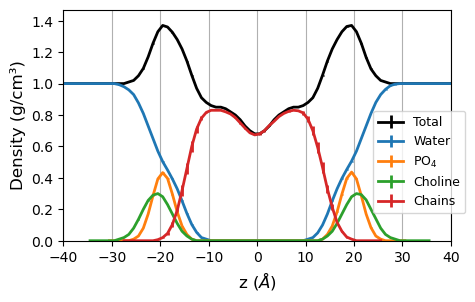

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

profiles = ["total", "water", "phosphate", "choline", "chains"]

plt.figure(figsize=(5,3))
for p in profiles:
    #print(p)
    dfdens=pd.read_table(f'./densityProfile-popc/dens_{p}_moyen.dat', sep="\s+")
    x, y, e = dfdens['x'], dfdens['dens_mean'], dfdens['std_error']
    if p=="total":
        plt.errorbar(x, y, e, color='k', linewidth=2)
        m=max(dfdens['dens_mean'])
    else:
        plt.errorbar(x, y, e, linewidth=2)

plt.legend(['Total', 'Water', 'PO$_4$', 'Choline', 'Chains'], loc=[0.8, 0.12], prop={'size':9})
plt.xlim(-40,40)
plt.ylim(0,m+0.1)
plt.grid(axis='x')
plt.xlabel('z ($\AA$)', style='normal', size=12)
plt.ylabel('Density (g/cm³)', style='normal', size=12)
dens_prof_plot='density-profile_plot.png'
plt.savefig(dens_prof_plot, bbox_inches='tight', transparent=True)
plt.show()

In [24]:
########ORIGINAL SCRIPT TO EXTRACT DATAS################
import pandas as pd
import numpy as np
import glob

profiles = ["total", "water", "phosphate", "choline", "chains"]
prof=profiles[4]

# Lecture des fichiers
file_list = sorted(glob.glob(f"./traj*/data/densityProfiles/profile-{prof}*600.dat"))
print(file_list)
# Construire la grille x positive commune
all_x_values = set()
for filename in file_list:
    if 'chains' in filename:
        df = pd.read_csv(filename, delim_whitespace=True, header=None, usecols=[0, 3], names=["x", "y"])
    else:
        df = pd.read_csv(filename, delim_whitespace=True, header=None, names=["x", "y"])
    all_x_values.update(x for x in df["x"])

x_full = sorted(all_x_values)
x_df_template = pd.DataFrame({"x": x_full})

# Liste des résultats à fusionner
all_results = [x_df_template.copy()]
curve_index = 1  # Compteur pour y1, y2, ..., y6

for filename in file_list:
    if 'chains' in filename:
        df = pd.read_csv(filename, delim_whitespace=True, header=None, usecols=[0, 3], names=["x", "y"])
    else:
        df = pd.read_csv(filename, delim_whitespace=True, header=None, names=["x", "y"])
    subset = df
    #display(subset)
    label = f"y{curve_index}"
    raw_col = f"{label}_raw"

    grouped = subset.groupby("x")["y"].mean().reset_index().rename(columns={"y": raw_col})
    grouped = pd.merge(x_df_template, grouped, on="x", how="left").fillna(0)

    final_df = grouped[["x", raw_col]]
    all_results.append(final_df.drop(columns="x"))

"""
    for sign, subset in [("neg", df[df["x"] < 0]), ("pos", df[df["x"] > 0])]:
        subset = subset.copy()
        subset["x"] = subset["x"].abs()

        label = f"y{curve_index}"
        raw_col = f"{label}_raw"
        norm_col = f"{label}_norm"

        # Grouper par x (si doublons), moyenne
        grouped = subset.groupby("x")["y"].mean().reset_index().rename(columns={"y": raw_col})
        grouped = pd.merge(x_df_template, grouped, on="x", how="left").fillna(0)

        # Normalisation
        total = grouped[raw_col].sum()
        grouped[norm_col] = grouped[raw_col] / total if total != 0 else grouped[raw_col]

        # Conserver les colonnes
        final_df = grouped[["x", raw_col, norm_col]]
        all_results.append(final_df.drop(columns="x"))

        curve_index += 1
"""
# Fusion finale
result = pd.concat(all_results, axis=1)

# Sauvegarde
result.to_csv(f"dens-{prof}.dat", sep="\t", index=False, float_format="%.6f")

# Moyennes et erreurs sur PMF
dens_cols = [col for col in result.columns if col.endswith("raw")]
dens_array = result[dens_cols].values

dens_stats = result[["x"]].copy()
dens_stats["dens_mean"] = np.mean(dens_array, axis=1)
dens_stats["std_dev"] = np.std(dens_array, axis=1, ddof=1)
dens_stats["std_error"] = dens_stats["std_dev"] / np.sqrt(len(dens_cols))

dens_stats.to_csv(f"dens_{prof}_moyen.dat", sep="\t", index=False, float_format="%.6f")

print("\nDensité moyenne et erreurs :")
print(dens_stats)

['./traj1/data/densityProfiles/profile-chains600.dat', './traj2/data/densityProfiles/profile-chains600.dat', './traj3/data/densityProfiles/profile-chains600.dat']

Densité moyenne et erreurs :
       x  dens_mean       std_dev     std_error
0  -27.5   0.000000  0.000000e+00  0.000000e+00
1  -26.5   0.000000  0.000000e+00  0.000000e+00
2  -25.5   0.000000  0.000000e+00  0.000000e+00
3  -24.5   0.000000  0.000000e+00  0.000000e+00
4  -23.5   0.000000  0.000000e+00  0.000000e+00
5  -22.5   0.000000  0.000000e+00  0.000000e+00
6  -21.5   0.000000  0.000000e+00  0.000000e+00
7  -20.5   0.006667  5.000000e-03  2.886751e-03
8  -19.5   0.020000  8.660254e-03  5.000000e-03
9  -18.5   0.046667  1.802776e-02  1.040833e-02
10 -17.5   0.103333  3.041381e-02  1.755942e-02
11 -16.5   0.193333  4.769696e-02  2.753785e-02
12 -15.5   0.320000  6.062178e-02  3.500000e-02
13 -14.5   0.460000  6.062178e-02  3.500000e-02
14 -13.5   0.600000  5.678908e-02  3.278719e-02
15 -12.5   0.710000  3.968627e-02  2.29

/tmp/ipykernel_5774/3989124230.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, header=None, usecols=[0, 3], names=["x", "y"])
/tmp/ipykernel_5774/3989124230.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, header=None, usecols=[0, 3], names=["x", "y"])
/tmp/ipykernel_5774/3989124230.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, header=None, usecols=[0, 3], names=["x", "y"])
/tmp/ipykernel_5774/3989124230.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep

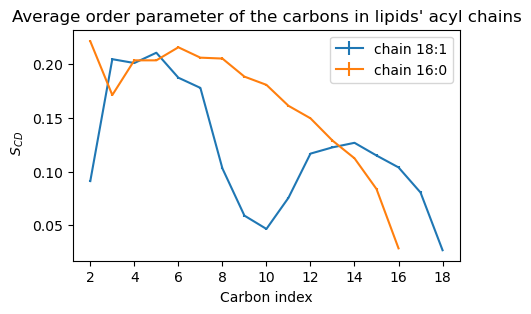

In [10]:
#Order parameters
plt.figure(figsize=(5,3))
chain=["chain2", "chain3"]
traj=[dop1, dop2, dop3]
for file in traj:
    for j in chain:
        #df1=pd.read_table(dop1.format(j,'1'), sep="\s+")
        df2=pd.read_table(file.format(j,'2'), sep="\s+")
        df3=pd.read_table(file.format(j,'3'), sep="\s+")
        df4=pd.read_table(file.format(j,'4'), sep="\s+")
        df5=pd.read_table(file.format(j,'5'), sep="\s+")
        #faire la moyenne
        df=pd.DataFrame()
        if j=='chain2':
            df['Carbon']=range(2, 19)
        else:
            df['Carbon']=range(2, 17)
        #2eme bloc
        df=df.merge(df2,how='left', on='Carbon')
        df.rename(columns={'-SCD': '-SCD2', 'STD_Error': 'STD_Error2'}, inplace=True)
        #3eme bloc
        df=df.merge(df3,how='left', on='Carbon')
        df.rename(columns={'-SCD': '-SCD3', 'STD_Error': 'STD_Error3'}, inplace=True)
        #4eme bloc
        df=df.merge(df4,how='left', on='Carbon')
        df.rename(columns={'-SCD': '-SCD4', 'STD_Error': 'STD_Error4'}, inplace=True)
        #5eme bloc
        df=df.merge(df5,how='left', on='Carbon')
        df.rename(columns={'-SCD': '-SCD5', 'STD_Error': 'STD_Error5'}, inplace=True)
        df['-SCD']=(df['-SCD2']+df['-SCD3']+df['-SCD4']+df['-SCD5'])/4
        df['STD_Error']=(df['STD_Error2']+df['STD_Error3']+df['STD_Error4']+df['STD_Error5'])/4
        df.drop(axis=0, columns=['-SCD2', '-SCD3', '-SCD4', '-SCD5', 'STD_Error2', 'STD_Error3', 'STD_Error4', 'STD_Error5'], inplace=True)
        if j=='chain2':
            if file==dop1:
                df_21=df
            elif file==dop2:
                df_22=df
            else:
                df_23=df
        else:
            if file==dop1:
                df_31=df
            elif file==dop2:
                df_32=df
            else:
                df_33=df

#merge chain2
df2=pd.DataFrame()
df2['Carbon']=range(2, 19)
df2=df2.merge(df_21,how='left', on='Carbon')
df2.rename(columns={'-SCD': '-SCD1', 'STD_Error': 'STD_Error1'}, inplace=True)
df2=df2.merge(df_22,how='left', on='Carbon')
df2.rename(columns={'-SCD': '-SCD2', 'STD_Error': 'STD_Error2'}, inplace=True)
df2=df2.merge(df_23,how='left', on='Carbon')
df2.rename(columns={'-SCD': '-SCD3', 'STD_Error': 'STD_Error3'}, inplace=True)
df2['-SCD']=(df2['-SCD1']+df2['-SCD2']+df2['-SCD3'])/3
df2['STD_Error']=(df2['STD_Error1']+df2['STD_Error2']+df2['STD_Error3'])/3
df2.drop(axis=0, columns=['-SCD1', '-SCD2', '-SCD3', 'STD_Error1', 'STD_Error2', 'STD_Error3'], inplace=True)

#merge chain3
df3=pd.DataFrame()
df3['Carbon']=range(2, 17)
df3=df3.merge(df_31,how='left', on='Carbon')
df3.rename(columns={'-SCD': '-SCD1', 'STD_Error': 'STD_Error1'}, inplace=True)
df3=df3.merge(df_32,how='left', on='Carbon')
df3.rename(columns={'-SCD': '-SCD2', 'STD_Error': 'STD_Error2'}, inplace=True)
df3=df3.merge(df_33,how='left', on='Carbon')
df3.rename(columns={'-SCD': '-SCD3', 'STD_Error': 'STD_Error3'}, inplace=True)
df3['-SCD']=(df3['-SCD1']+df3['-SCD2']+df3['-SCD3'])/3
df3['STD_Error']=(df3['STD_Error1']+df3['STD_Error2']+df3['STD_Error3'])/3
df3.drop(axis=0, columns=['-SCD1', '-SCD2', '-SCD3', 'STD_Error1', 'STD_Error2', 'STD_Error3'], inplace=True)

#print(df5)
#plt.plot(df5['Carbon'], df5['-SCD'], label='bloc {}'.format(i), linewidth=1.0)
plt.errorbar(df2['Carbon'], df2['-SCD'], df2['STD_Error'], label='chain 18:1', linestyle=None)
plt.errorbar(df3['Carbon'], df3['-SCD'], df3['STD_Error'], label='chain 16:0', linestyle=None)

plt.legend()
plt.xlabel('Carbon index')
plt.ylabel('$\ S_{CD}$')
plt.title('Average order parameter of the carbons in lipids\' acyl chains')
plt.savefig(order_par_plot, bbox_inches='tight', transparent=True)
plt.show()
